### This file contains Constraint-Kmeans alg. and relaed test results.
### Contents
*  I. n/a
* II. Helper functions
* III. Main function
* IV. Test & plots

In [2]:
import pandas as pd
import numpy as np
import os 
from collections import Counter
import matplotlib.pyplot as plt
import pickle
import time
from pulp import *
import random as rd
import math
import random as rd

## II. Helper functions 

In [3]:
# find cenriod for empty clusters: 
def furthest_centroids(j,k,lable,features):
    centroids = get_centroids(features, lable, j)
    for index in range(j,k):
        temp = -1
        furthest = 0
        for i in range(len(features)):
            if lable[i] is None:
                dis = sum([euclidean_d(features[i],x) for x in centroids])
                if dis>temp:
                    temp = dis
                    furthest = i
        lable[furthest] = index
        centroids = centroids + [features[index]]
    return centroids,lable

# return the lable of a cluster that is most similar to the unassigned group
def fit_lable(group,features,lable,ub,k):
    temp = 1000000
    lable_of_closest = 0
    for i in range(k):
        seeds = [x for x in range(len(lable)) if lable[x] == i]
        if len(seeds) + len(group)>ub: continue
        dis = group_d(seeds, group,features)
        if  dis < temp:
            temp = dis
            lable_of_closest = i
    return lable_of_closest

# return group distance
def group_d(g1,g2,features):
    d = 0
    for i in g1:
        for j in g2:
            d += euclidean_d(features[i],features[j])
    return d

# return object distance
def euclidean_d(a,b):
    return math.sqrt(sum([(x-y)*(x-y) for (x,y) in zip(a,b)]))

# get centriod
def get_centroids(features, lable, k):
    centroids = []
    for i in range(k):
        seeds = [x for x in range(len(lable)) if lable[x] == i]
        centroids.append(np.mean(np.array([features[x] for x in seeds]), axis=0))
    return centroids

# end condition 
def shouldStop(oldCentroids, centroids, iterations, alpha, MAX_ITERATIONS):
    if oldCentroids is None: return False
    if iterations > MAX_ITERATIONS: return True
    if sum([euclidean_d(x,y)>alpha for (x,y) in zip(oldCentroids,centroids)]) == 0: return True
    return False

# update lable
def get_lable(features, lable, centroids, free, ub, k):
    for i in free:
        if lable[i] is not None and sum([1 for x in lable if lable[i]==x])==1: continue
        temp = 100000
        lable_of_closest = 0
        for j in range(k):
            if len([x for x in range(len(lable)) if lable[x] == j])<ub:
                dis = euclidean_d(centroids[j],features[i])
                if dis< temp:
                    temp = dis
                    lable_of_closest = j
        lable[i] = lable_of_closest
    return lable

## III. Main function 

In [4]:
def cons_km(features, ml, k, ub = 6, MAX_ITERATIONS = 100, alpha = 0.5):
    
    """Clustering with must-link constraints and upper bound for cluster size.

    Args:
        features: An array with shape (n_objects,n_features)
        mustlink: A list containing the pre-defined group, ex.[[a,b],[c,d,e]] 
        k: Number of clusters
        ub: Upper bound for the cardinality of clusters. 
        iterations: max number of iterations
        alpha
        
    Returns:
        k clusters.
        
    Raises:
        IOError: An error occurred when the given upper bound is not attainable.
    """
    
    ml.sort(key = len)
    ml = ml[::-1]
    lable = [None]*len(features)
    fix = []
    for group in ml:
        fix = fix + group
    free = [x for x in range(len(features)) if x not in fix]

    #initialize seeds
    if k > len(ml): 
        for i in range(len(ml)):
            for member in ml[i]:
                lable[member] = i
        centroids, lable = furthest_centroids(len(ml),k,lable,features)
    else:
        for i in range(k):
            for member in ml[i]:
                lable[member] = i
        for i in range(k,len(ml)):
            temp = fit_lable(ml[i],features,lable,ub,k)
            for member in ml[i]:
                lable[member] = temp
        centroids = get_centroids(features, lable, k)
                
    #k means:
    iterations = 0
    oldCentroids = None
    
    while not shouldStop(oldCentroids, centroids, iterations, alpha,MAX_ITERATIONS):
        # Save old centroids for convergence test. Book keeping.
        oldCentroids = centroids
        iterations += 1
        
        lable = get_lable(features, lable, centroids, free, ub, k)

        centroids = get_centroids(features, lable, k)

    print(iterations)
    return centroids,lable

## IV. Test on Randam data

3
d [6, 7]
> [19, 18]
< [12, 13]
+ [1, 4, 5]


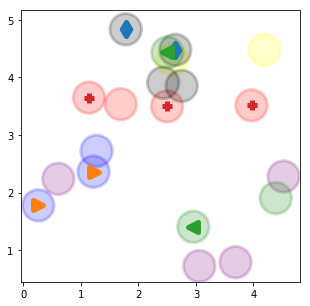

In [7]:
# random generate 20 points
f = [[rd.uniform(0,5),rd.uniform(0,5)] for x in range(20)]
mlml = [[1,4,5],[6,7],[19,18],[12,13]]

#constraints-kmean
cen,lab = cons_km(features=f,ml=mlml,k=6,alpha=0.5,MAX_ITERATIONS=1000,ub=4)

# visualize it
plt.figure(figsize=(5,5),)
colors = ['red', 'green','blue','black','yellow','purple']
plt.scatter([x[0] for x in f], [x[1] for x in f], s=1000, c=[colors[x] for x in lab],lw=3,alpha =0.2)

markers = ['x','+','<','>','d']
for group in mlml:
    temp = markers.pop()
    print(temp,group)
    plt.scatter([f[x][0] for x in group], [f[x][1] for x in group], s=100,lw=5,marker=temp)
plt.show()

1001
1001
1001
1001
1001
1001
1001
32


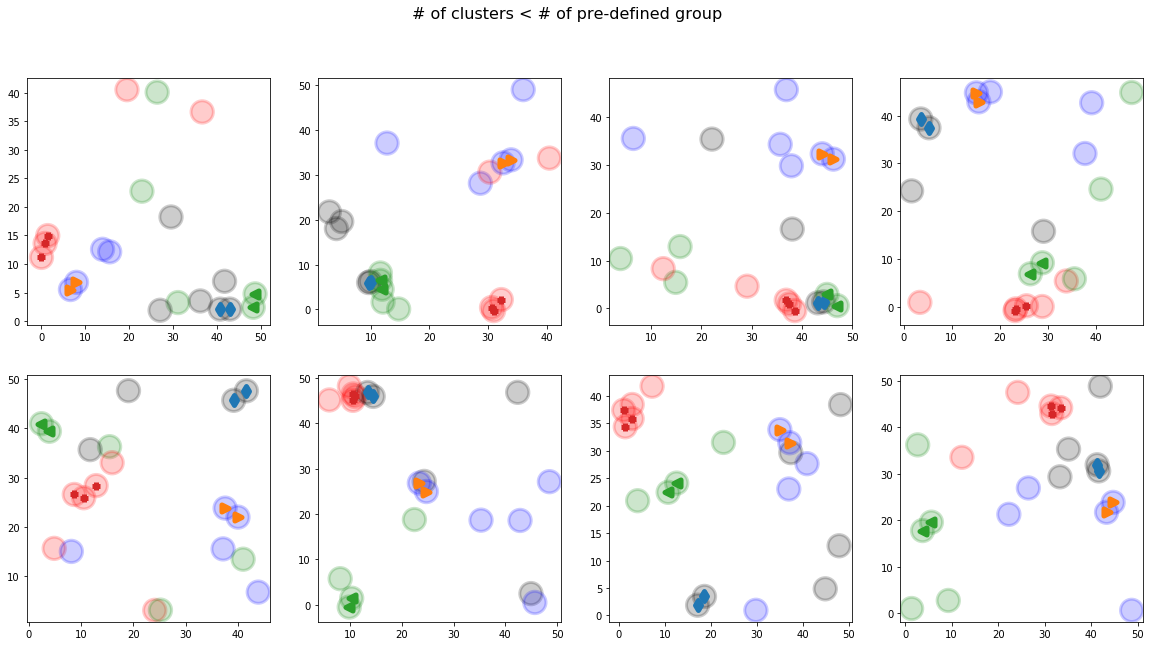

In [8]:
'''
Test on 20 data points
1.forced similarity within pre-fixed group 
2.# of clusters < # of pre-defined group
'''

fig, ax = plt.subplots(nrows=2, ncols=4,figsize=(20,10))
fig.suptitle('# of clusters < # of pre-defined group', fontsize=16)

for row in ax:
    for col in row:
        #random generate 20 points
        f = [[rd.uniform(0,50),rd.uniform(0,50)] for x in range(20)]
        mlml = [[1,4,5],[6,7],[19,18],[12,13]]
        
        # make group similar:
        for group in mlml:
            for i in range(1,len(group)):
                f[group[i]][0] = f[group[0]][0] + rd.uniform(-2.5,2.5)
                f[group[i]][1] = f[group[0]][1] + rd.uniform(-2.5,2.5)
                
        #constraints-kmean
        cen,lab = cons_km(features=f,ml=mlml,k=4,alpha=0.5,MAX_ITERATIONS=1000)

        # visualize it
        
        colors = ['red', 'green','blue','black']
        col.scatter([x[0] for x in f], [x[1] for x in f], s=500, c=[colors[x] for x in lab],lw=3,alpha =0.2)

        markers = ['x','+','<','>','d']
        for group in mlml:
            temp = markers.pop()
            col.scatter([f[x][0] for x in group], [f[x][1] for x in group], s=50,lw=5,marker=temp)

plt.show()

1001
1001
1001
1001
1001
1001
1001
1001


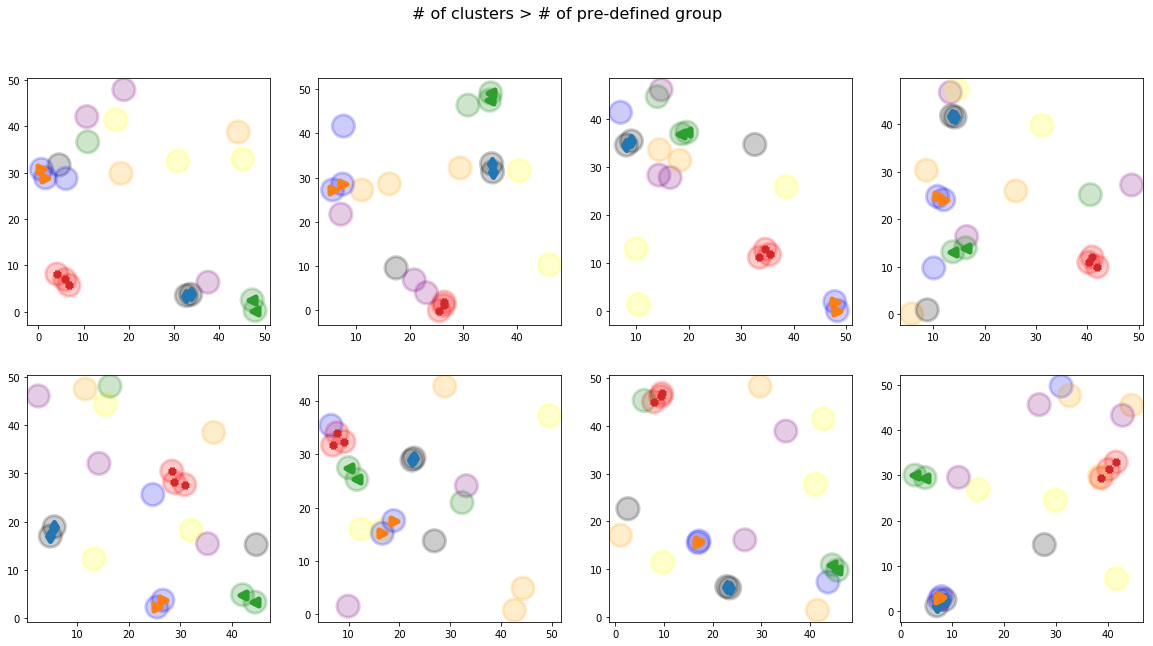

In [405]:
'''
Test on 20 data points with:
1.forced similarity within pre-fixed group 
2.# of clusters > # of pre-defined group
'''

fig, ax = plt.subplots(nrows=2, ncols=4,figsize=(20,10))
fig.suptitle('# of clusters > # of pre-defined group', fontsize=16)

for row in ax:
    for col in row:
        #random generate 20 points
        f = [[rd.uniform(0,50),rd.uniform(0,50)] for x in range(20)]
        mlml = [[1,4,5],[6,7],[19,18],[12,13]]
        
        # make group similar:
        for group in mlml:
            for i in range(1,len(group)):
                f[group[i]][0] = f[group[0]][0] + rd.uniform(-2.5,2.5)
                f[group[i]][1] = f[group[0]][1] + rd.uniform(-2.5,2.5)
                
        #constraints-kmean
        cen,lab = cons_km(features=f,ml=mlml,k=7,alpha=0.5,MAX_ITERATIONS=1000,ub=3)

        # visualize it
        
        colors = ['red', 'green','blue','black','purple','yellow','orange']
        col.scatter([x[0] for x in f], [x[1] for x in f], s=500, c=[colors[x] for x in lab],lw=3,alpha =0.2)

        markers = ['x','+','<','>','d']
        for group in mlml:
            temp = markers.pop()
            col.scatter([f[x][0] for x in group], [f[x][1] for x in group], s=50,lw=5,marker=temp)

plt.show()

## V. Test on blob data

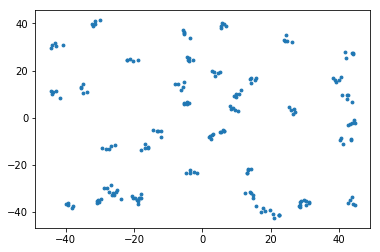

In [20]:
# generate data with ground true 

import sklearn.datasets as sk_data

X, y = sk_data.make_blobs(n_samples=200, centers=40, n_features=2,
                          center_box=(-45.0, 45.0),random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=8)
plt.show()

In [53]:
# generate must-links
def must_links_generators(X,k,lb,ub):
    """generates k pre-defined groups among the objects represented by X

    Args:
        X: Objects matrix
        k: Number of pre-defined groups
        lb,ub: Size of group subjects to (lb,ub)
    Returns:
        A 2d list that represents k pre-defined group.
    Raise:
        IOError if cannot generate k satisfying groups
    """
    must_links = [] 
    pool = [x for x in range(len(X))]
    for i in range(k):
        if len(pool) == 0: raise IOError("k or size too large")
        rd.shuffle(pool)
        size = rd.randint(2,4)
        must_links.append(pool[-size:])
        pool = pool[:-size]
    return must_links

In [60]:
a = must_links_generators(X,10,1,3)
a

[[138, 174, 150, 186],
 [19, 166, 38, 66],
 [129, 47],
 [46, 114, 76, 167],
 [103, 78, 125, 37],
 [9, 85, 23],
 [113, 105, 177],
 [142, 2, 136, 64],
 [69, 159, 143],
 [81, 179, 49]]

In [57]:
X.tolist()

[[-35.09486466818733, 14.135906514883882],
 [-29.563151678197375, -12.837241484148834],
 [-18.671540606535807, -34.297416959302026],
 [-26.885102849202095, -28.822592594160465],
 [24.536075134794235, 35.2306253960307],
 [5.688856946732268, 40.15296117481884],
 [14.119158033524696, -32.0696976023438],
 [11.240946609801044, 11.603678310764947],
 [30.229988003883008, -37.15879177715968],
 [-43.248585835695316, 31.649128820963778],
 [15.698822554644881, 16.659254495199345],
 [44.40134671197139, -1.1018025442906618],
 [6.796305255466342, 38.71115928258061],
 [9.779602075970802, 8.848055912398149],
 [-20.330002523950665, -34.29269878984169],
 [-35.64815858151946, 12.859942788826329],
 [-4.410066075156725, 6.640536871951829],
 [13.415055747494172, -22.047051916147243],
 [-17.88425189368835, -34.035409529725584],
 [42.7962901661395, -36.12825928380317],
 [-2.333573293825095, -22.997925830769486],
 [28.64650322421532, -35.995661496799556],
 [-22.145939911076347, 24.33505027338012],
 [-25.659452

In [62]:
#constraints-kmean
mlml = must_links_generators(X,10,2,3)
f = X.tolist()
print('pk')
%timeit cen,lab = cons_km(features=f,ml=mlml,k=40,alpha=0.5,MAX_ITERATIONS=1000,ub=4)

# visualize it
plt.figure(figsize=(5,5),)
colors = ['red', 'green','blue','black','yellow','purple']
plt.scatter([x[0] for x in f], [x[1] for x in f], s=1000, c=[colors[x] for x in lab],lw=3,alpha =0.2)

markers = ['x','+','<','>','d']
for group in mlml:
    temp = markers.pop()
    print(temp,group)
    plt.scatter([f[x][0] for x in group], [f[x][1] for x in group], s=100,lw=5,marker=temp)
plt.show()

pk
1001
1001
1001


KeyboardInterrupt: 